In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 데이터셋

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
def normalize_and_resize_img(dataset):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(dataset['image'], [224, 224])
    dataset['image'] = tf.cast(image, tf.float32) / 255.
    return dataset['image'], dataset['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [67]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test, is_test=True)

## 모델 구현 및 학습

In [5]:
# class 수 추출
num_classes = ds_info.features["label"].num_classes

# model : resnet50
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output

# GAP 이후 softmax Dense 추가
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [6]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [8]:
EPOCHS = 10

In [9]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCHS,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 188s 235ms/step - loss: 2.1721 - accuracy: 0.4484 - val_loss: 3.7497 - val_accuracy: 0.1606
Epoch 2/10
750/750 [==============================] - 176s 234ms/step - loss: 0.7718 - accuracy: 0.7831 - val_loss: 1.1836 - val_accuracy: 0.6594
Epoch 3/10
750/750 [==============================] - 163s 218ms/step - loss: 0.2493 - accuracy: 0.9463 - val_loss: 0.9554 - val_accuracy: 0.7199
Epoch 4/10
750/750 [==============================] - 175s 234ms/step - loss: 0.0694 - accuracy: 0.9927 - val_loss: 0.8913 - val_accuracy: 0.7430
Epoch 5/10
750/750 [==============================] - 163s 217ms/step - loss: 0.0317 - accuracy: 0.9979 - val_loss: 0.9135 - val_accuracy: 0.7441
Epoch 6/10
750/750 [==============================] - 163s 217ms/step - loss: 0.0179 - accuracy: 0.9993 - val_loss: 0.9100 - val_accuracy: 0.7452
Epoch 7/10
750/750 [==============================] - 163s 217ms/step - loss: 0.0126 - accuracy: 0.9998 - val_loss: 0.9263 -

In [11]:
cam_model.save('assets/cam_model.h5')

In [13]:
import json

with open('assets/history_cam_model.json', 'w') as f:
    json.dump(history_cam_model.history, f)

## model history

In [4]:
cam_model = tf.keras.models.load_model('assets/cam_model.h5')

In [5]:
import json

with open('assets/history_cam_model.json', 'r') as f:
    history_cam_model = json.load(f)

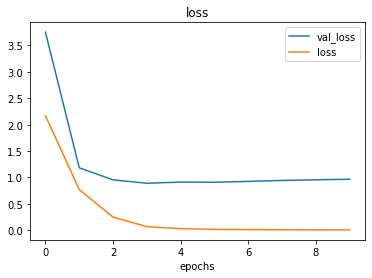

In [6]:
import matplotlib.pyplot as plt


plt.plot(history_cam_model['val_loss'], label='val_loss')
plt.plot(history_cam_model['loss'], label='loss')
plt.xlabel('epochs')
plt.title('loss')
plt.legend()
plt.show()

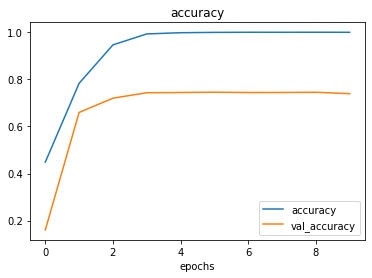

In [7]:
plt.plot(history_cam_model['accuracy'], label='accuracy')
plt.plot(history_cam_model['val_accuracy'], label='val_accuracy')
plt.xlabel('epochs')
plt.title('accuracy')
plt.legend()
plt.show()

## 실습

### CAM(Class Activation Map) 정의

In [8]:
import copy

def generate_cam(model, item):
    # item copy 후, 크기 추출
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # img,class normalization
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # GAP 전 Layer 추출 : model.layer[-3]
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # model weight 추출
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적 -> 활성화 정도 표현
        cam_image += w * conv_outputs[:, :, i]
    
    # activation score를 normalize
    cam_image /= np.max(cam_image) 
    cam_image = cam_image.numpy()
    # 원본 크기로 resize
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

### Grad-CAM 정의

In [110]:
# Grad-CAM 정의
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 원하는 Layer를 추출하기 위한 Model output 변형
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient 추출
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
       
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### IoU, Bounding Box 시각화

In [73]:
import cv2

# CAM에서의 bbox 가져오기
def get_bbox(cam_image, score_thresh=0.05):
    cam_image = copy.deepcopy(cam_image)
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [13]:
# bbox 좌표 가져오기
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [14]:
# IoU 출력(pred, true)
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

### CAM 및 GRAD-CAM 실습

In [16]:
cam_model = tf.keras.models.load_model('assets/cam_model.h5')

In [92]:
# dataset에서 무작위 1개 추출
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [93]:
# cam과 image 합성
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [248]:
item = get_one(ds_test)
origin_image = item['image'].astype(np.uint8)

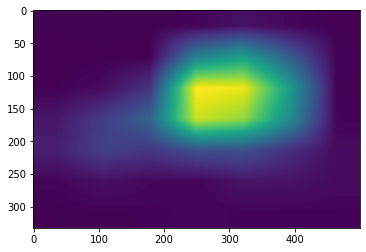

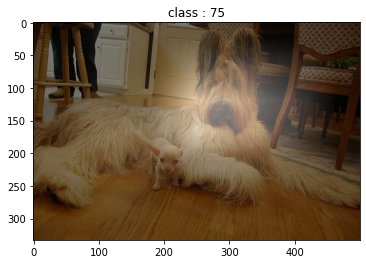

In [249]:
cam_image = generate_cam(cam_model, item)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

# cam 이미지 출력
plt.imshow(cam_image)
plt.show()

plt.imshow(visualize_cam_on_image(origin_image, cam_image_3channel))
plt.title(f'class : {item["label"]}')
plt.show()

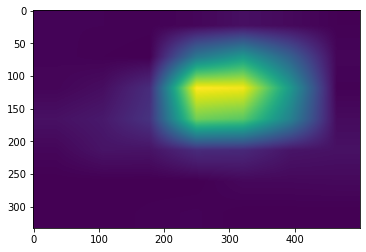

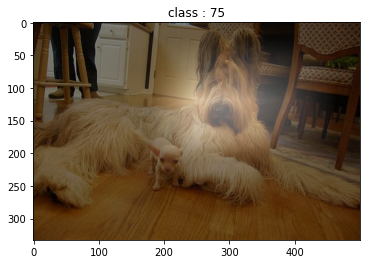

In [250]:
activation_layer = 'conv5_block3_out'
grad_cam_image = generate_grad_cam(cam_model, activation_layer, item) 
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

# cam 이미지 출력
plt.imshow(grad_cam_image)
plt.show()

plt.imshow(visualize_cam_on_image(origin_image, grad_cam_image_3channel))
plt.title(f'class : {item["label"]}')
plt.show()

**감상평**
- 미묘한 차이는 있지만 각각이 보는 방향은 비슷한듯 하다.

### iou 실습

In [239]:
def show_bbox_true_pred(item, cam_image, score_thresh=0.05):
    # cam image에서 bbox rect 추출
    rect = get_bbox(cam_image, score_thresh)
    pred_bbox = rect_to_minmax(rect, item['image'])
    
    # 추출한 rect 그리기
    image = copy.deepcopy(item['image'])
    bbox_image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    
    # 실제 bbox 가져오기
    true_bbox = (item['objects']['bbox']).reshape(-1)
    y_min, x_min, y_max, x_max = true_bbox
    top_left = (int(x_min*image.shape[1]), int(y_min*image.shape[0]))
    bottom_right = (int(x_max*image.shape[1]), int(y_max*image.shape[0]))
    # 실제 bbox 그리기
    bbox_image = cv2.rectangle(image, top_left, bottom_right, (255,0,0),2)
    # iou
    iou = get_iou(pred_bbox, true_bbox)
    return bbox_image, iou

0.7095910033635163


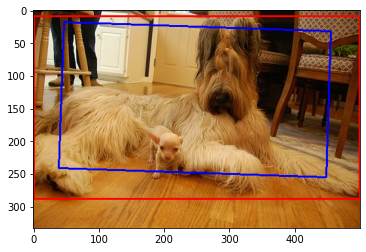

In [251]:
# cam image
score_thresh=0.09
pred_cam_rect = get_bbox(cam_image, score_thresh)
pred_cam_bbox = rect_to_minmax(pred_cam_rect, item['image'])

iou_bbox_image, iou = show_bbox_true_pred(item, cam_image, score_thresh)
print(iou)
plt.imshow(iou_bbox_image)
plt.show()

0.6381079434255249


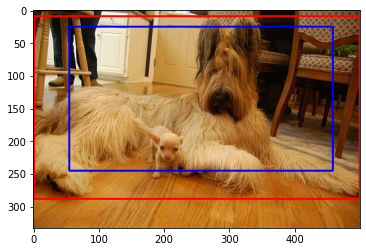

In [252]:
# grad cam image
score_thresh=0.05
pred_grad_cam_rect = get_bbox(grad_cam_image, score_thresh)
pred_grad_cam_bbox = rect_to_minmax(pred_grad_cam_rect, item['image'])

iou_bbox_image, iou = show_bbox_true_pred(item, grad_cam_image, score_thresh)
print(iou)
plt.imshow(iou_bbox_image)
plt.show()

### 다양한 score_threshold 실험
- 점점 강조되는 부분을 보여줌

In [242]:
score_threshs = [round(i * 0.025, 3) for i in range(1, 20)]
score_threshs

[0.025,
 0.05,
 0.075,
 0.1,
 0.125,
 0.15,
 0.175,
 0.2,
 0.225,
 0.25,
 0.275,
 0.3,
 0.325,
 0.35,
 0.375,
 0.4,
 0.425,
 0.45,
 0.475]

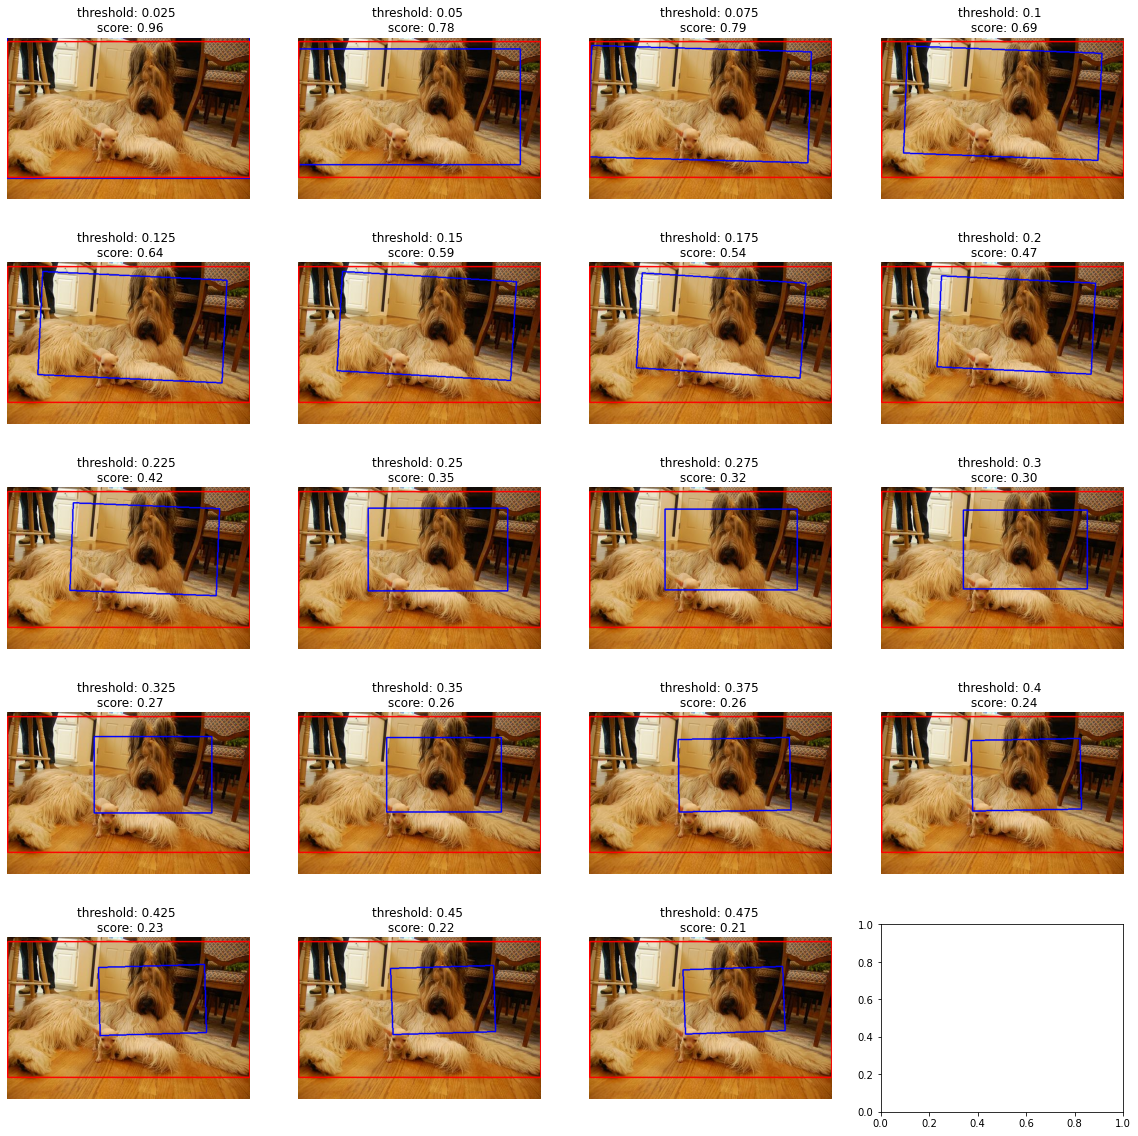

In [253]:
fig, axes = plt.subplots(5,4, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    if i >= len(score_threshs): break
    iou_bbox_image, iou = show_bbox_true_pred(item, cam_image, score_threshs[i])
    ax.set_title(f'threshold: {score_threshs[i]} \n score: {iou:.2f}')
    ax.imshow(iou_bbox_image)
    ax.axis('off')

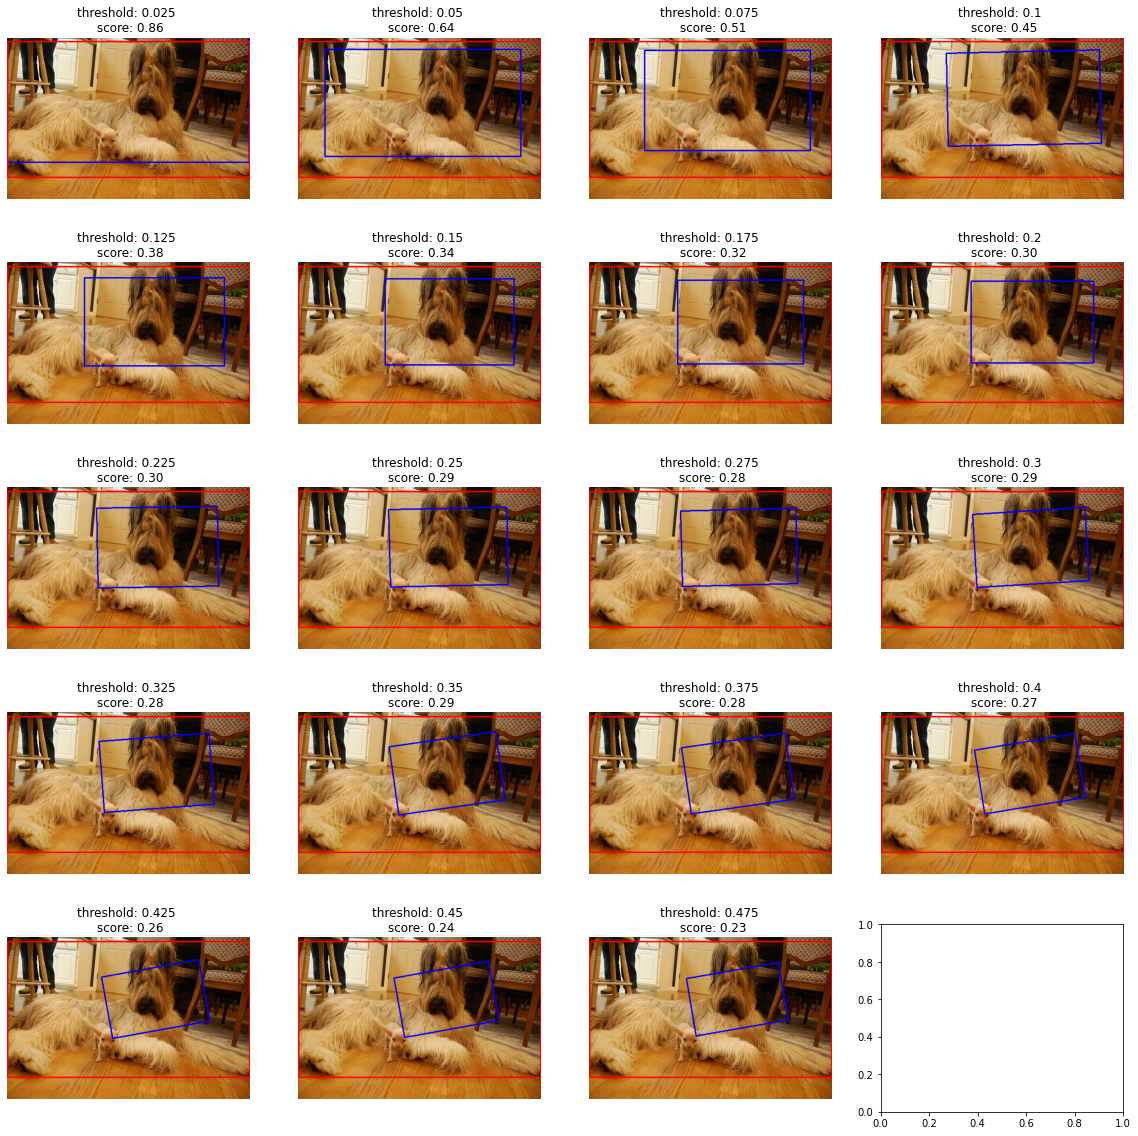

In [254]:
fig, axes = plt.subplots(5,4, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    if i >= len(score_threshs): break
    iou_bbox_image, iou = show_bbox_true_pred(item, grad_cam_image, score_threshs[i])
    ax.set_title(f'threshold: {score_threshs[i]} \n score: {iou:.2f}')
    ax.imshow(iou_bbox_image)
    ax.axis('off')

- Threshold가 높다고 IoU Score가 높아지는 것은 아님
    - Treshold를 높이면 bbox를 강조하는 부분에 더 가깝게 맞춰져 pred_bbox가 좁아짐

### 다른 이미지는 어떨까?

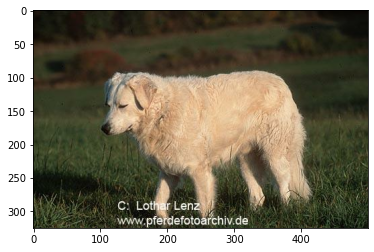

In [255]:
item = get_one(ds_test)
origin_image = item['image'].astype(np.uint8)
plt.imshow(origin_image)
plt.show()

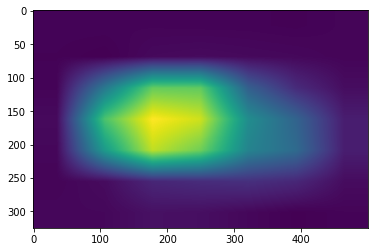

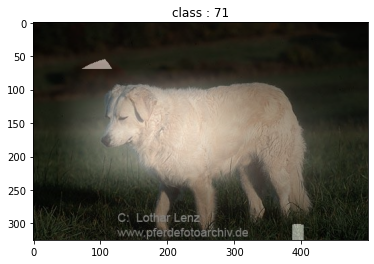

In [257]:
cam_image = generate_cam(cam_model, item)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

# cam 이미지 출력
plt.imshow(cam_image)
plt.show()

plt.imshow(visualize_cam_on_image(origin_image, cam_image_3channel))
plt.title(f'class : {item["label"]}')
plt.show()

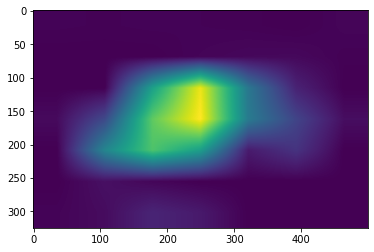

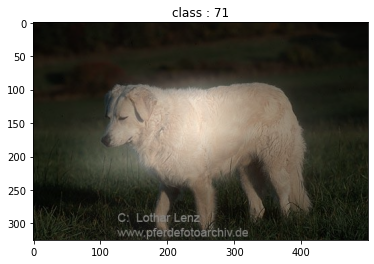

In [261]:
activation_layer = 'conv5_block3_out'
grad_cam_image = generate_grad_cam(cam_model, activation_layer, item) 
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

# cam 이미지 출력
plt.imshow(grad_cam_image)
plt.show()

plt.imshow(visualize_cam_on_image(origin_image, grad_cam_image_3channel))
plt.title(f'class : {item["label"]}')
plt.show()

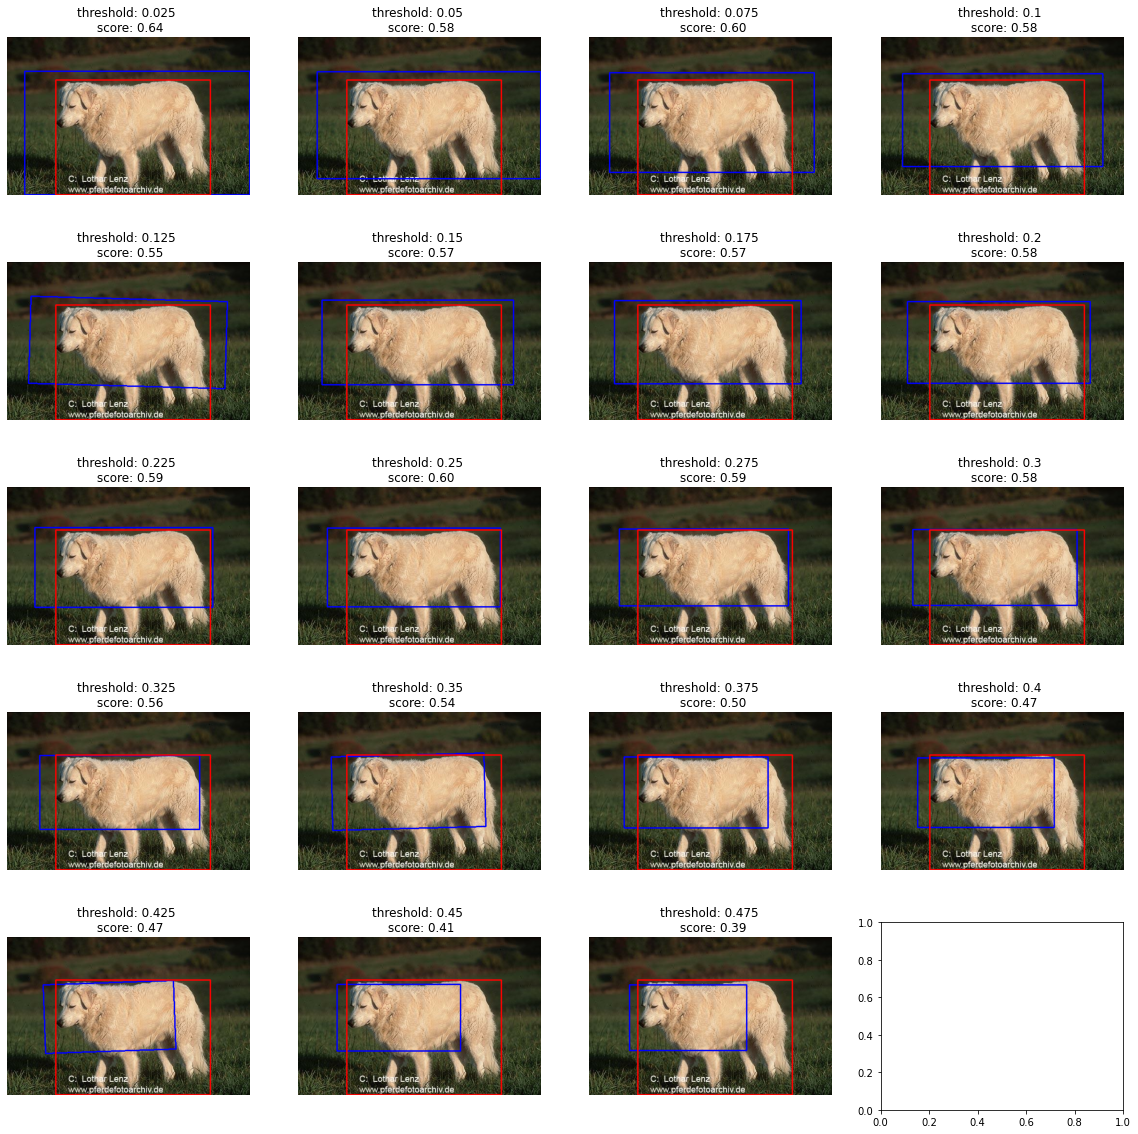

In [262]:
fig, axes = plt.subplots(5,4, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    if i >= len(score_threshs): break
    iou_bbox_image, iou = show_bbox_true_pred(item, cam_image, score_threshs[i])
    ax.set_title(f'threshold: {score_threshs[i]} \n score: {iou:.2f}')
    ax.imshow(iou_bbox_image)
    ax.axis('off')

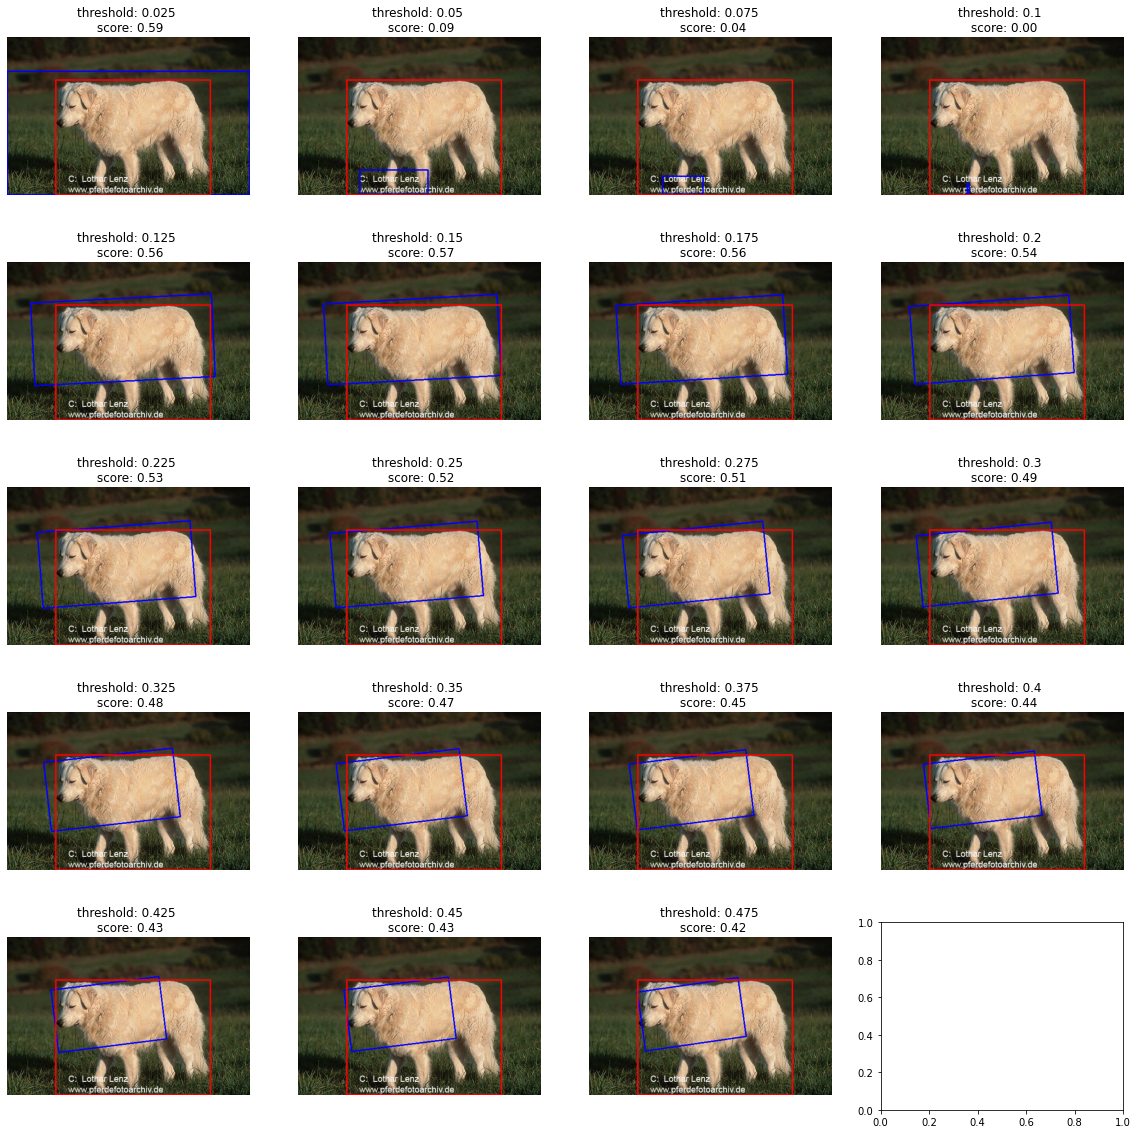

In [263]:
fig, axes = plt.subplots(5,4, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    if i >= len(score_threshs): break
    iou_bbox_image, iou = show_bbox_true_pred(item, grad_cam_image, score_threshs[i])
    ax.set_title(f'threshold: {score_threshs[i]} \n score: {iou:.2f}')
    ax.imshow(iou_bbox_image)
    ax.axis('off')

- 특히, Grad-CAM 부분을 보면 threshold에 따라 Bbox가 제대로 동작이 안되는 모습을 볼 수 있음
    - 0.05~0.1까지 이상 현상이 존재
- 무엇이 문제일까?

## 회고
### 배운점
- CAM 구현을 통해 Image 분류를 위해 Model이 무엇을 보고 판단하는지 볼 수 있게 됨.
- IoU 구현을 통해 pred와 true bounding box의 차이가 얼마나 나는지 볼 수 있게 됨.

### 아쉬운점
- 마지막 부분 threshold에 따라 bbox가 튀는 현상이 있는데 해당 현상이 왜 일어나는지 실습을 하지 못함.